# **Curso**: Deep Learning

[<img align="right" width="400" height="100" src="https://assets.website-files.com/5f909dbbf6ef7c3b428e2522/60f4592942eda3c0ffb35bfd_Logo_QLAB.svg">](https://qlab.pucp.edu.pe/)


[Pedro Achanccaray](mailto:p.diaz@tu-braunschweig.de), y [Smith Arauco](mailto:saraucoc@uni.pe).

[Pontificia Universidad Católica del Perú](https://www.pucp.edu.pe/)  
[Laboratorio de Inteligencia Artificial y Métodos Computacionales en Ciencias Sociales](https://qlab.pucp.edu.pe/formacion-continua)

# **Lab 2: Convolutional Neural Network (CNN) para clasificación de imágenes**

En esta sesión vamos a ver los siguientes temas:
- Convolutional Neural Networks
- Data augmentation
- Batch normalization
- Dropout

Vamos a usar el conjunto de datos [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) para clasificación de imágenes.

Este conjunto de datos tiene las siguientes clases:

<center>

| Clase | Descripción |
|:-----:|:-----------:|
|   0   | T-shirt/top |
|   1   |   Trouser   |
|   2   |  Pullover   |
|   3   |   Dress     |
|   4   |   Coat      |
|   5   |    Sandal   |
|   6   |    Shirt    |
|   7   |    Sneaker  |
|   8   |     Bag     |
|   9   |  Ankle boot |

</center>

Algunas muestras del conjunto de datos:

<center>

<img src="https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true" height=400/>

</center>

## **Montar Google Drive a Google Colab**

**Ejecutar las siguiente lineas de código solo si deseas guardar el módelo entrenado.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/DL_QLAB/Deep_Learning/Semana_2

/content/drive/MyDrive/DL_QLAB/Deep_Learning/Semana_2


## Cargando el conjunto de datos

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.utils import plot_model, to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import shuffle

Vamos a cargar el conjunto de datos.

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Ahora crearemos tres conjuntos:
- Entrenamiento (train),
- Validación (validation),
- Pruebas (testing)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  stratify=y_train,
                                                  test_size=0.1)

print("Training: Data ({}), Labels ({})".format(x_train.shape, y_train.shape))
print("Validation: Data ({}), Labels ({})".format(x_val.shape, y_val.shape))
print("Testing: Data ({}), Labels ({})".format(x_test.shape, y_test.shape))

Training: Data ((54000, 28, 28)), Labels ((54000,))
Validation: Data ((6000, 28, 28)), Labels ((6000,))
Testing: Data ((10000, 28, 28)), Labels ((10000,))


### **Preprocesamiento**

In [8]:
# (#,28,28) => (#,28,28,1)
# uint8 => float
# [0,255] => [0,1]
x_train = np.expand_dims(x_train, axis=-1).astype("float32")/255.0
x_val = np.expand_dims(x_val, axis=-1).astype("float32")/255.0
x_test = np.expand_dims(x_test, axis=-1).astype("float32")/255.0

In [9]:
name_labels = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

n_classes = len(name_labels)

### **Visualización**

Veamos algunas muestras del conjunto de datos

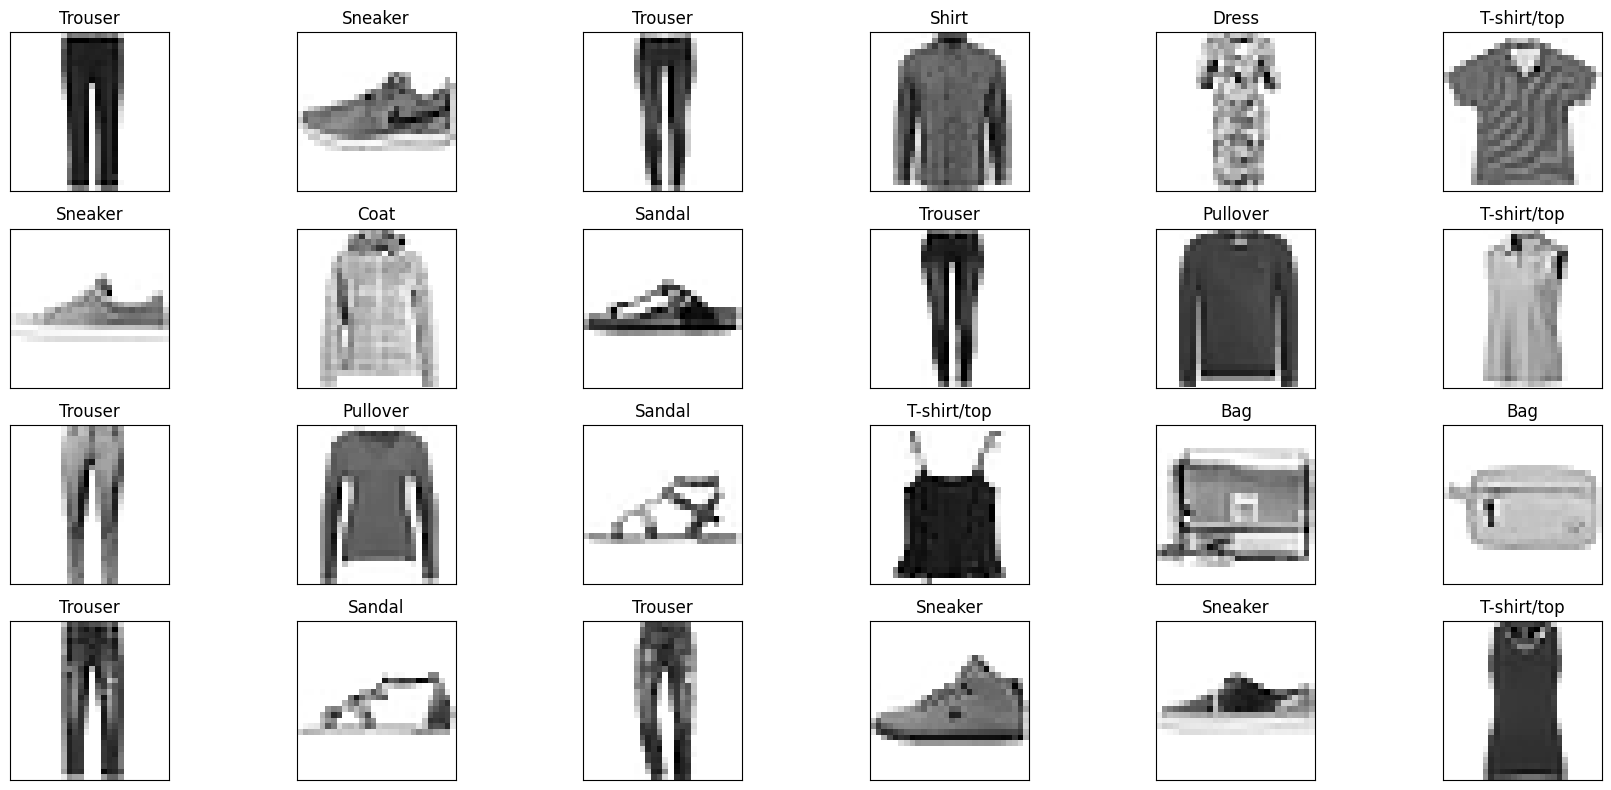

In [10]:
rows = 4
columns = 6
n = rows*columns

images = x_train[:n]
labels = y_train[:n]

fig, axes = plt.subplots(rows,
                         columns,
                         figsize=(3*columns,2*rows))

for i in range(n):
  ax = axes[i//columns, i%columns]
  ax.imshow(images[i].reshape(28,28), cmap=plt.cm.binary)
  ax.set_title('{}'.format(name_labels[labels[i]]))
  ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.show()

## **Generador de datos**

Con la clase [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) podemos aplicar diferentes transformaciones para el aumento de datos (_data augmentation_)

In [11]:
batch_size = 32

# Generador para Entrenamiento, con flips horizontal y vertical
gen_train = ImageDataGenerator(horizontal_flip=True,
                               vertical_flip=True)
# Generador para Validación
gen_val = ImageDataGenerator()

data_gen_train = gen_train.flow(x_train,
                                y_train,
                                batch_size=batch_size)

data_gen_val = gen_val.flow(x_val,
                            y_val,
                            batch_size=batch_size)

**Preguntas:**
- ¿Aplicamos aumento de datos (data augmentation) en el conjunto de validación?
- ¿Aplicamos aumento de datos (data augmentation) en el conjunto de pruebas (test)?

Tambien podemos visualizar la salida del generador de datos luego de aplicar aumento de datos.

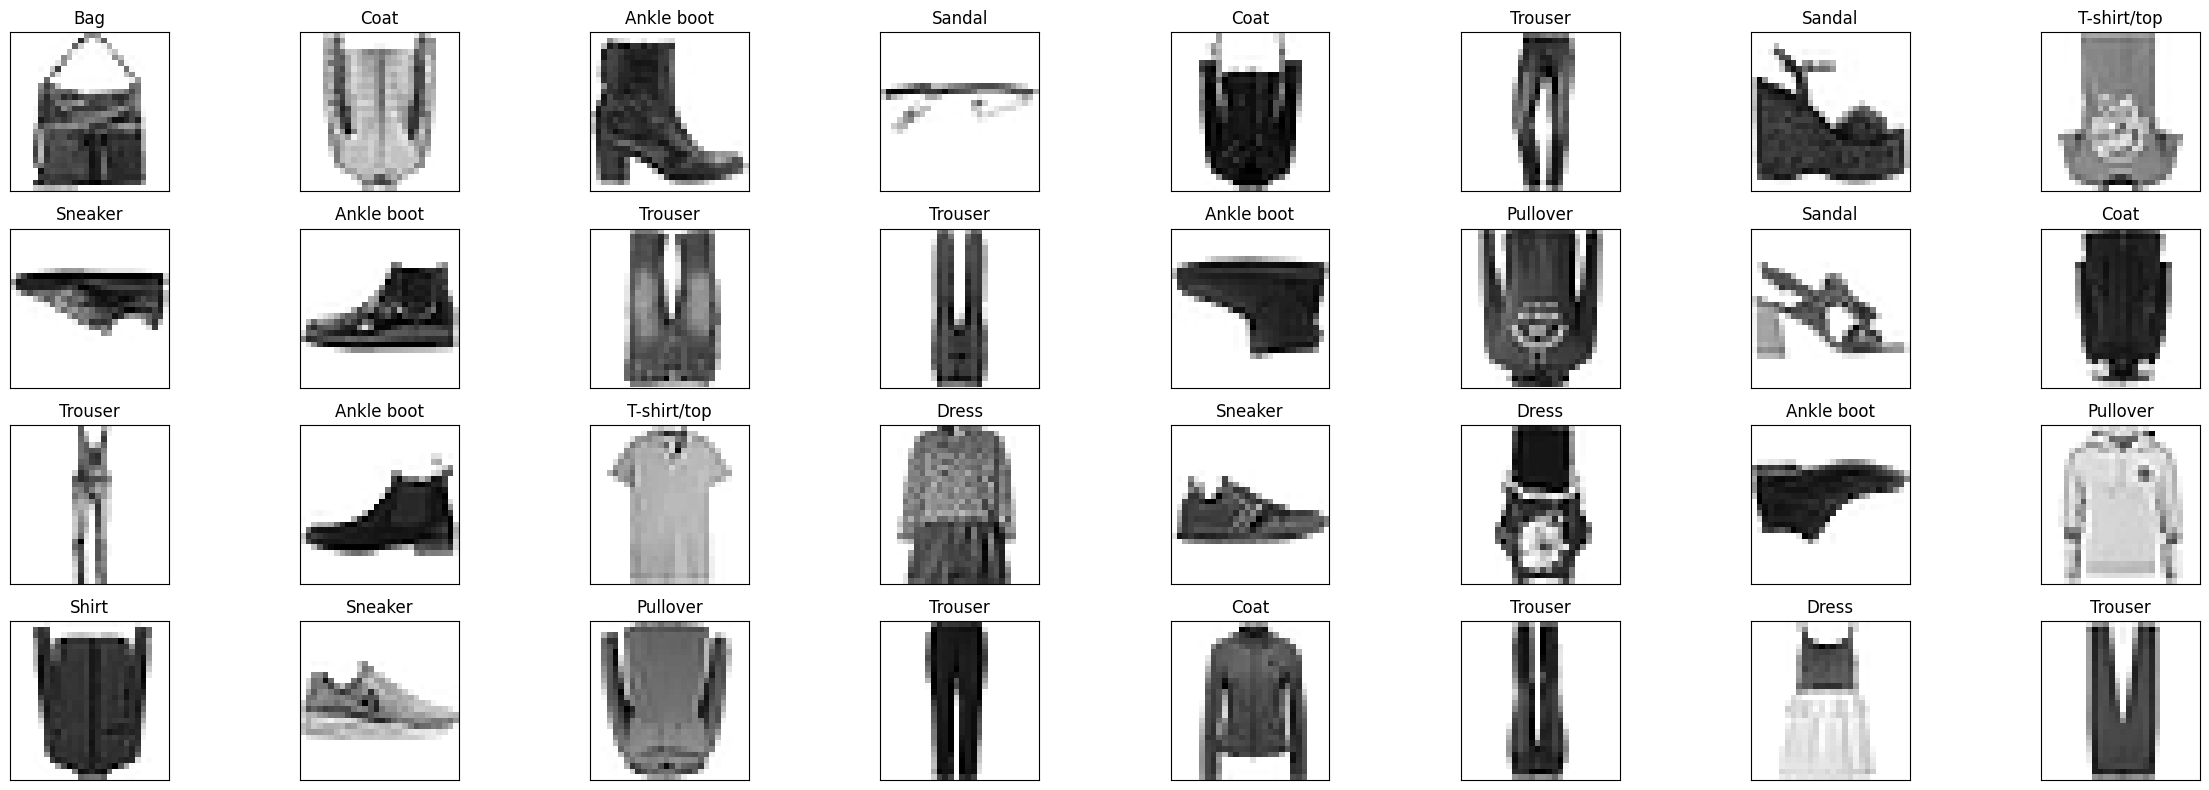

In [14]:
x_batch, y_batch = data_gen_train.next()

rows = 4
columns = 8
n = rows*columns

fig, axes = plt.subplots(rows,
                         columns,
                         figsize=(3*columns,2*rows))

for i in range(n):
  ax = axes[i//columns, i%columns]
  ax.imshow(x_batch[i].reshape(28,28), cmap=plt.cm.binary)
  ax.set_title('{}'.format(name_labels[y_batch[i]]))
  ax.set_xticks([]), ax.set_yticks([])
plt.tight_layout()
plt.show()

## **Modelo de clasificación de imágenes**

Usemos una Red Neuronal Convolucional con las siguientes características:
- Capas convolucionales, $k=(3,3)$
- Capas max pooling, $k=(2,2)$


Keras nos ofrece diferentes APIs para implementar nuestro modelo: **Sequential API** y **Functional API**.

- **Sequential API**
```python
model = Sequential()
model.add(...)
model.add(...)
```
Simple, mejor parar **modelos lineales** con una **única entrada** y una **única salida**.


- **Functional API**
```python
input_layer = Input(shape=(...))
layer_1 = Dense(...)(input_layer)
layer_2 = Dense(...)(layer_1)
output_layer = Dense(...)(layer_2)
model = Model(inputs=input_layer, outputs=output_layer)
```
Más flexible, mejor para modelos complejos con **multiples entradas** y **multiples salidas**.

### **Funciones para crear modelos convolucionales**

Vamos a usar las siguiente capas para construir nuestro modelo de clasificación
- [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/): capa convolucional 2D donde tenemos que definir el tamaño del kernel, padding, número de kernels y la función de activación.
- [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/): capa para aplicar Batch Normalization. Esta capa no tiene parámetros de entrada ni parámetros entrenables.
- [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/): capa para aplicar max pooling 2D donde tenemos que indicar el tamaño del kernel para aplicar el pooling.
- [Dropout](https://keras.io/api/layers/regularization_layers/dropout/): capa para aplicar dropout donde tenemos que indicar la probabilidad con la que cada neurona será desactivada.

#### **Sequential API**

In [16]:
# Using sequential API
def get_model(filters,
              n_classes,
              k=3,
              name="my_model",
              padding="same",
              batch_norm=False,
              dropout=None):
  model = Sequential(name=name)
  # Convolutional block 1
  model.add(Conv2D(filters[0],
                   (k,k),
                   input_shape=(28,28,1),
                   activation="relu",
                   padding=padding))
  # Batch normalization
  if batch_norm: model.add(BatchNormalization())
  # Max pooling
  model.add(MaxPooling2D(2,2))
  # Dropout
  if dropout is not None: model.add(Dropout(dropout))

  # More convolutional blocks
  for n in filters[1:]:
    model.add(Conv2D(n,
                     (k,k),
                     activation="relu",
                     padding=padding))
    # Batch normalization
    if batch_norm: model.add(BatchNormalization())
    # Max pooling
    model.add(MaxPooling2D(2,2))
    # Dropout
    if dropout is not None: model.add(Dropout(dropout))

  # Flatten and output layer
  model.add(Flatten())
  # Dense layers
  model.add(Dense(100,
                  activation="relu"))
  model.add(Dense(n_classes,
                  activation="softmax"))

  # Configuración del modelo
  model.compile(optimizer=Adam(learning_rate=0.001),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy']
                )
  return model

#### **Functional API**

In [17]:
# Using Functional API
def get_model_funct(filters,
                    n_classes,
                    k=3,
                    name="my_model",
                    padding="same",
                    batch_norm=False,
                    dropout=None):
  input_layer = Input(shape=(28,28,1))
  # Convolutional block 1
  x = Conv2D(filters[0],
             (k,k),
             activation="relu",
             padding=padding)(input_layer)
  # Batch normalization
  if batch_norm: x = BatchNormalization()(x)
  # Max pooling
  x = MaxPooling2D(2,2)(x)
  # Dropout
  if dropout is not None: x = Dropout(dropout)(x)

  # More convolutional blocks
  for n in filters[1:]:
    x = Conv2D(n,
               (k,k),
               activation="relu",
               padding=padding)(x)
    # Batch normalization
    if batch_norm: x = BatchNormalization()(x)
    # Max pooling
    x = MaxPooling2D(2,2)(x)
    # Dropout
    if dropout is not None: x = Dropout(dropout)(x)

  x = Flatten()(x)
  # Dense layers
  x = Dense(100,
            activation="relu")(x)
  output_layer = Dense(n_classes,
                       activation="softmax")(x)
  # Modelo final
  model = Model(inputs=input_layer, outputs=output_layer, name=name)

  # Configuración del modelo
  model.compile(optimizer=Adam(learning_rate=0.001),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy']
                )
  return model

### **Creando los modelos**

In [25]:
model_cnn_1 = get_model(filters=[32],
                        n_classes=n_classes,
                        name="CNN_1")

model_cnn_2 = get_model(filters=[32, 64],
                        n_classes=n_classes,
                        name="CNN_2_BN",
                        batch_norm=True)

model_cnn_3 = get_model_funct(filters=[32, 64],
                              n_classes=n_classes,
                              name="CNN_3_BN_Drop",
                              batch_norm=True,
                              dropout=0.3)

### **Número de parámetros**

Veamos el número de parámetros de cada modelo.

Recuerden que cada capa convolucional tiene kernels o filtros de $3\times 3$

El primero modelo tiene 320 parámetros en la primera capa: $32⋅(3⋅3 + 1)=320$

In [26]:
model_cnn_1.summary()
print("\n\n")
model_cnn_2.summary()
print("\n\n")
model_cnn_3.summary()

Model: "CNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                                 
 dense_12 (Dense)            (None, 100)               627300    
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                                 
Total params: 628630 (2.40 MB)
Trainable params: 628630 (2.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________

In [27]:
print("Model:{}, Parameters:{}".format(model_cnn_1.name,
                                       model_cnn_1.count_params()))

print("Model:{}, Parameters:{}".format(model_cnn_2.name,
                                       model_cnn_2.count_params()))

print("Model:{}, Parameters:{}".format(model_cnn_3.name,
                                       model_cnn_3.count_params()))

Model:CNN_1, Parameters:628630
Model:CNN_2_BN, Parameters:333910
Model:CNN_3_BN_Drop, Parameters:333910


**Preguntas:**
- ¿Cuál modelo tiene más parametros?
- ¿Por qué ese modelo tiene más parámetros?

### **Visualizando los modelos**

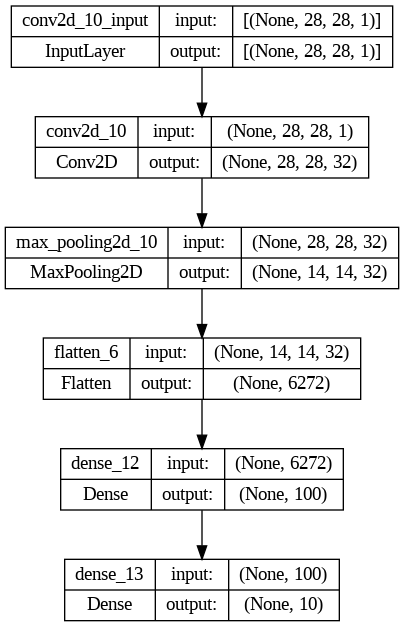

In [29]:
plot_model(model_cnn_1, to_file="model_cnn_1.png", show_shapes=True)

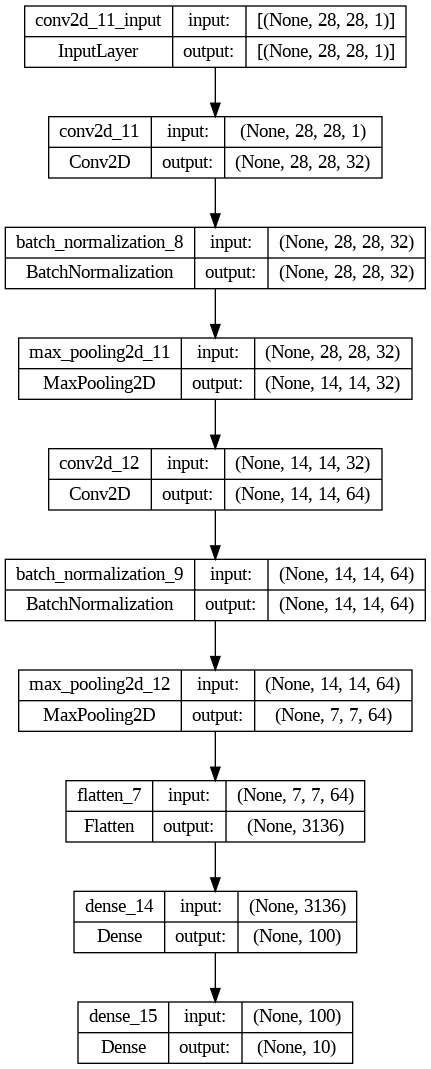

In [30]:
plot_model(model_cnn_2, to_file="model_cnn_2.png", show_shapes=True)

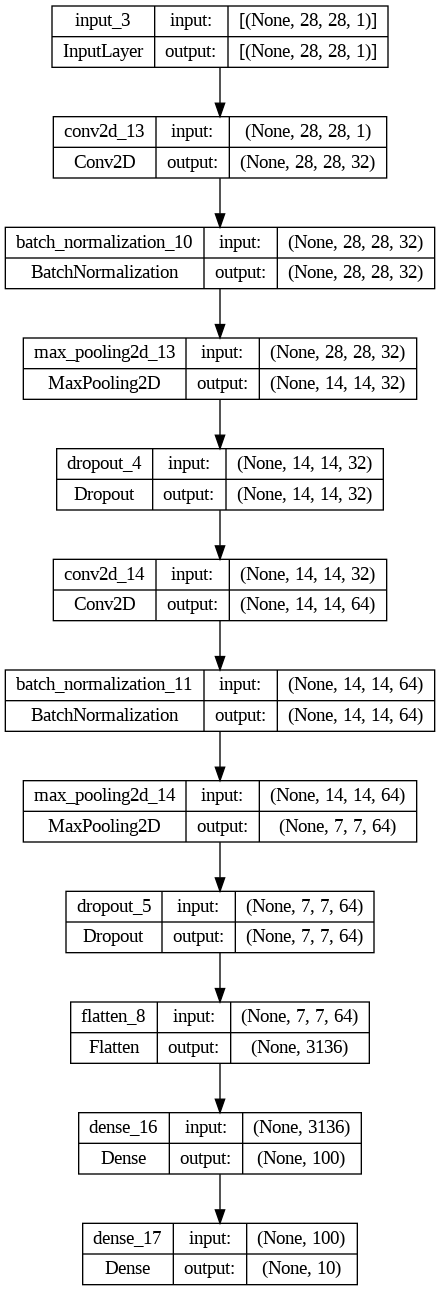

In [31]:
plot_model(model_cnn_3, to_file="model_cnn_3.png", show_shapes=True)

## **Configuración del entrenamiento**

Podemos usar diferentes [callbacks](https://keras.io/api/callbacks/) que serán ejecutados durante el entrenamiento del modelo:
- [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/): callback para guardar el mejor modelo de acuerdo a la métrica de interes seleccionada.
- [EarlyStopping](https://keras.io/api/callbacks/early_stopping/): callback para detener el entrenamiento del modelo si la métrica de interes seleccionada no mejora luego de un determinado número de épocas.
- [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/): callback para disminuir el `learning rate` cada determinado número de épocas.
- [TensorBoard](https://keras.io/api/callbacks/tensorboard/): callback para generar los archivos necesarios para visualizar el entrenamiento en tiempo real usando TensorBoard.

In [34]:
def get_ckpt(ckpt_name):
  return ModelCheckpoint(ckpt_name,
                         mode="max",
                         save_best_only=True,
                         monitor="val_accuracy",
                         verbose=1)

In [35]:
# Callbacks
# ModelCheckpoint guardara el modelo cada vez que exista una mejora
# en el accuracy del conjunto de validación
mode_autosave_cnn_1 = get_ckpt("classification_model_cnn_1.h5")
mode_autosave_cnn_2 = get_ckpt("classification_model_cnn_2.h5")
mode_autosave_cnn_3 = get_ckpt("classification_model_cnn_3.h5")

# EarlyStopping terminara el entrenamiento si no existe una mejora
# en el accuracy en 40 epocas
early_stopping = EarlyStopping(patience=40,
                               verbose=1,
                               mode="auto")

callbacks_cnn_1 = [mode_autosave_cnn_1, early_stopping]
callbacks_cnn_2 = [mode_autosave_cnn_2, early_stopping]
callbacks_cnn_3 = [mode_autosave_cnn_3, early_stopping]

## **Entrenando el modelo**

In [36]:
history_cnn_1 = model_cnn_1.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_1
                                )

Epoch 1/200
1683/1688 [============================>.] - ETA: 0s - loss: 0.4991 - accuracy: 0.8222
Epoch 1: val_accuracy improved from -inf to 0.86050, saving model to classification_model_cnn_1.h5
1688/1688 [==============================] - 22s 6ms/step - loss: 0.4989 - accuracy: 0.8224 - val_loss: 0.4004 - val_accuracy: 0.8605
Epoch 2/200
   8/1688 [..............................] - ETA: 12s - loss: 0.4034 - accuracy: 0.8672

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1683/1688 [============================>.] - ETA: 0s - loss: 0.3438 - accuracy: 0.8789
Epoch 2: val_accuracy improved from 0.86050 to 0.88400, saving model to classification_model_cnn_1.h5
1688/1688 [==============================] - 11s 6ms/step - loss: 0.3439 - accuracy: 0.8789 - val_loss: 0.3315 - val_accuracy: 0.8840
Epoch 3/200
1682/1688 [============================>.] - ETA: 0s - loss: 0.3077 - accuracy: 0.8888
Epoch 3: val_accuracy improved from 0.88400 to 0.88667, saving model to classification_model_cnn_1.h5
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3078 - accuracy: 0.8887 - val_loss: 0.3159 - val_accuracy: 0.8867
Epoch 4/200
1686/1688 [============================>.] - ETA: 0s - loss: 0.2796 - accuracy: 0.8983
Epoch 4: val_accuracy improved from 0.88667 to 0.89467, saving model to classification_model_cnn_1.h5
1688/1688 [==============================] - 11s 6ms/step - loss: 0.2794 - accuracy: 0.8984 - val_loss: 0.2943 - val_accuracy: 0.8947
Epoch 5

In [37]:
history_cnn_2 = model_cnn_2.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_2
                                )

Epoch 1/200
1687/1688 [============================>.] - ETA: 0s - loss: 0.4632 - accuracy: 0.8339
Epoch 1: val_accuracy improved from -inf to 0.85033, saving model to classification_model_cnn_2.h5
1688/1688 [==============================] - 14s 7ms/step - loss: 0.4632 - accuracy: 0.8339 - val_loss: 0.4245 - val_accuracy: 0.8503
Epoch 2/200
  11/1688 [..............................] - ETA: 8s - loss: 0.3513 - accuracy: 0.8722 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1682/1688 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8826
Epoch 2: val_accuracy improved from 0.85033 to 0.88583, saving model to classification_model_cnn_2.h5
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3244 - accuracy: 0.8827 - val_loss: 0.3140 - val_accuracy: 0.8858
Epoch 3/200
1679/1688 [============================>.] - ETA: 0s - loss: 0.2899 - accuracy: 0.8935
Epoch 3: val_accuracy did not improve from 0.88583
1688/1688 [==============================] - 10s 6ms/step - loss: 0.2898 - accuracy: 0.8936 - val_loss: 0.3126 - val_accuracy: 0.8850
Epoch 4/200
1682/1688 [============================>.] - ETA: 0s - loss: 0.2656 - accuracy: 0.9036
Epoch 4: val_accuracy improved from 0.88583 to 0.88617, saving model to classification_model_cnn_2.h5
1688/1688 [==============================] - 11s 7ms/step - loss: 0.2654 - accuracy: 0.9036 - val_loss: 0.3244 - val_accuracy: 0.8862
Epoch 5/200
1688/1688 [==============================] - E

In [38]:
history_cnn_3 = model_cnn_3.fit(data_gen_train,
                                epochs=200,
                                validation_data=data_gen_val,
                                callbacks=callbacks_cnn_3
                                )

Epoch 1/200
1682/1688 [============================>.] - ETA: 0s - loss: 0.5322 - accuracy: 0.8068
Epoch 1: val_accuracy improved from -inf to 0.86567, saving model to classification_model_cnn_3.h5
1688/1688 [==============================] - 14s 7ms/step - loss: 0.5317 - accuracy: 0.8070 - val_loss: 0.3719 - val_accuracy: 0.8657
Epoch 2/200
1687/1688 [============================>.] - ETA: 0s - loss: 0.3760 - accuracy: 0.8615
Epoch 2: val_accuracy improved from 0.86567 to 0.86967, saving model to classification_model_cnn_3.h5
1688/1688 [==============================] - 11s 6ms/step - loss: 0.3760 - accuracy: 0.8615 - val_loss: 0.3643 - val_accuracy: 0.8697
Epoch 3/200
1687/1688 [============================>.] - ETA: 0s - loss: 0.3383 - accuracy: 0.8746
Epoch 3: val_accuracy improved from 0.86967 to 0.89000, saving model to classification_model_cnn_3.h5
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3383 - accuracy: 0.8746 - val_loss: 0.2874 - val_accuracy: 0.890

In [39]:
print(history_cnn_1.history.keys())
print(history_cnn_2.history.keys())
print(history_cnn_3.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## **Evolución del modelo durante el entrenamiento**

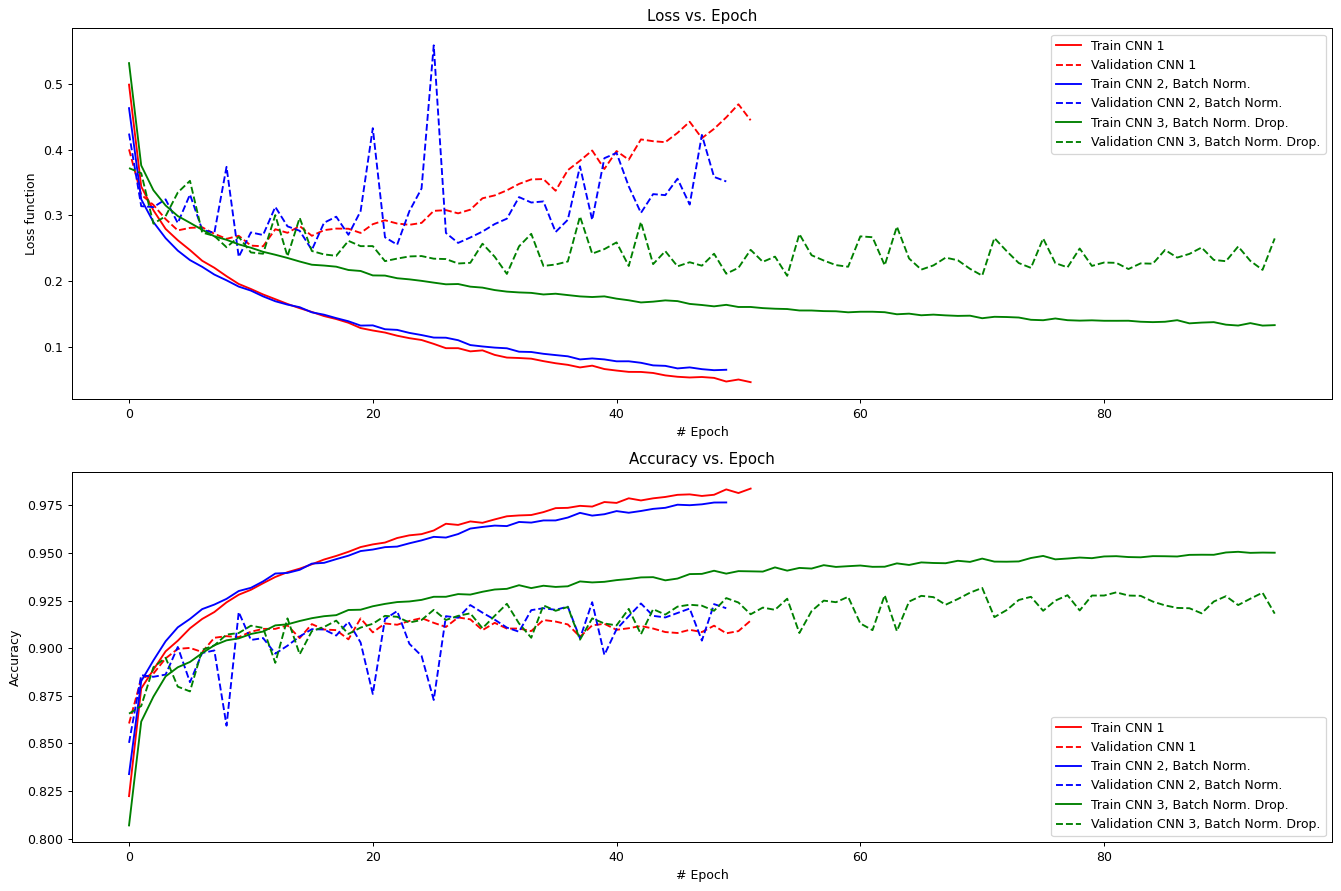

In [45]:
fig_labels = ["Train CNN 1",
              "Validation CNN 1",
              "Train CNN 2, Batch Norm.",
              "Validation CNN 2, Batch Norm.",
              "Train CNN 3, Batch Norm. Drop.",
              "Validation CNN 3, Batch Norm. Drop."]

plt.figure(figsize=(15,10), dpi=90)

plt.subplot(2,1,1)
plt.plot(history_cnn_1.history["loss"], "r-")
plt.plot(history_cnn_1.history["val_loss"], "r--")
plt.plot(history_cnn_2.history["loss"], "b-")
plt.plot(history_cnn_2.history["val_loss"], "b--")
plt.plot(history_cnn_3.history["loss"], "g-")
plt.plot(history_cnn_3.history["val_loss"], "g--")
plt.xlabel("# Epoch")
plt.ylabel("Loss function")
plt.legend(fig_labels)
plt.title("Loss vs. Epoch")

plt.subplot(2,1,2)
plt.plot(history_cnn_1.history["accuracy"], "r-")
plt.plot(history_cnn_1.history["val_accuracy"], "r--")
plt.plot(history_cnn_2.history["accuracy"], "b-")
plt.plot(history_cnn_2.history["val_accuracy"], "b--")
plt.plot(history_cnn_3.history["accuracy"], "g-")
plt.plot(history_cnn_3.history["val_accuracy"], "g--")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy")
plt.legend(fig_labels)
plt.title("Accuracy vs. Epoch")

plt.tight_layout()

plt.show()

**Pregunta**: ¿Qué podemos observar de estas figuras?

## **Cargando los pesos del modelo**

Si ya se entrenaron los modelos, podemos comenzar desde este punto para no volver a entrenar el modelo.

In [46]:
model_cnn_1.load_weights("classification_model_cnn_1.h5")
model_cnn_2.load_weights("classification_model_cnn_2.h5")
model_cnn_3.load_weights("classification_model_cnn_3.h5")

## **Probando el modelo**

Definimos un generador para el conjunto de pruebas o test

In [47]:
gen_test = ImageDataGenerator()

data_gen_test = gen_train.flow(x_test,
                               y_test,
                               batch_size=batch_size)

Calculamos las métricas y el valor del loss function para cada modelo en cada set: entrenamiento, validación y pruebas:

In [48]:
print("Entrenamiento:")
scores_train_1 = model_cnn_1.evaluate(data_gen_train)
scores_train_2 = model_cnn_2.evaluate(data_gen_train)
scores_train_3 = model_cnn_3.evaluate(data_gen_train)

print("Validación:")
scores_val_1 = model_cnn_1.evaluate(data_gen_val)
scores_val_2 = model_cnn_2.evaluate(data_gen_val)
scores_val_3 = model_cnn_3.evaluate(data_gen_val)

print("Pruebas:")
scores_test_1 = model_cnn_1.evaluate(data_gen_test)
scores_test_2 = model_cnn_2.evaluate(data_gen_test)
scores_test_3 = model_cnn_3.evaluate(data_gen_test)

Entrenamiento:
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0991 - accuracy: 0.9639
Validación:
188/188 [==============================] - 1s 4ms/step - loss: 0.2083 - accuracy: 0.9317
Pruebas:
313/313 [==============================] - 1s 5ms/step - loss: 0.2354 - accuracy: 0.9249


**Pregunta:** Según los siguientes resultados, ¿Cuál modelo es el mejor?

<center>

|Loss &darr; |Entrenamiento |Validación | -  |Accuracy &uarr; |Entrenamiento |Validación|
|-----|------:|---------:|------|----|--------:|-----:|
|CNN 1|0.0851|0.3031|- |             |97.1| 91.6 |
|CNN 2|**0.0700**|0.2931|- |             |**97.5**| 92.4 |
|CNN 3|0.0991|**0.2083**|- |             |96.4|**93.2**|

</center>

<br/>
<br/>

<details>
  <summary>Resultados en el conjunto de pruebas</summary>
  
  <center>

  |Loss &darr; |Pruebas| -|Accuracy &uarr; |Pruebas|
  |-----|------:|--|---------|-----:|
  |CNN 1|0.3316 |- | |90.9|
  |CNN 2|0.3309|- | |91.8|
  |CNN 3|**0.2354**|- |  |**92.5**|

  </center>

</details>

## **Tarea 1**

Hemos definido un `pipeline` para clasificación de imágenes usando CNNs. Este `pipeline` puede ser modificado de diferentes maneras.

Entonces, pruebe una modificación del `pipeline` para clasificación de imágenes. Para ellos, modifique uno o más de los siguientes componentes:
- **Arquitectura de la red** (tamaño de kernel: $k$, filtros: $[16,32,64,128]$, más convoluciones seguidas):

  ```python
  def get_model_funct(filters,
                      n_classes,
                      k=3,
                      name="my_model",
                      padding="same",
                      batch_norm=False,
                      dropout=None):

    input_layer = Input(shape=(28,28,1))
    x = Conv2D(filters[0], (k,k), activation="relu", padding=padding)(input_layer)
    # x = Conv2D(filters[0], (k,k), activation="relu", padding=padding)(x)
    # x = Conv2D(filters[0], (k,k), activation="relu", padding=padding)(x)
  ```


- **Comparar diferentes optimizadores ([Keras Optmizers](https://keras.io/api/optimizers/))**:

  ```python
  from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

  model.compile(optimizer=Adam(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=['accuracy']
                )
  ```
- **Usar otras transformacion para aumento de datos ([ImageDataGenerator documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator))**





- **Deadline:** 21.10.2023
- **Archivos:** Link del Colab, o descargar el archivo (*.ipynb) y enviarlo por email, o link al repositorio en GitHub
- **E-mail:** p.diaz@tu-braunschweig.de, p.diaz@tu-bs.de (ambos son el mismo correo)